# Homework

---

### Q1

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*

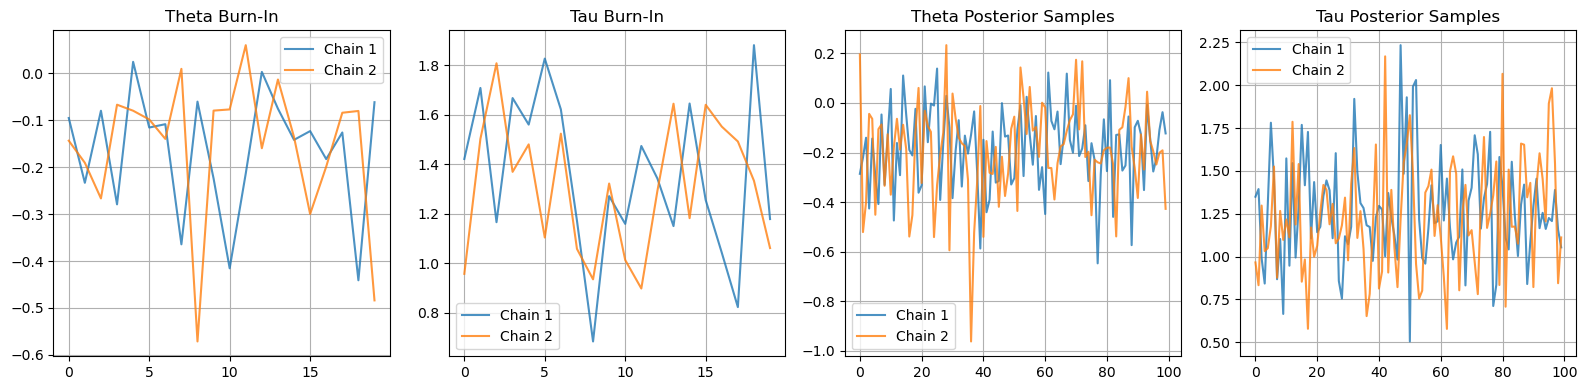

In [4]:
#Q1

# Import necessary libraries
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the Gibbs sampler
def gibbs_sampler(data, num_samples=10000, burn_in=1000, chains=2):
    """
    Gibbs sampler for posterior inference of theta and tau.
    """
    n = len(data)  # Number of data points
    x_mean = np.mean(data)  # Mean of the data
    
    # Initialize storage for theta and tau samples
    theta_samples = np.zeros((chains, num_samples))
    tau_samples = np.zeros((chains, num_samples))
    
    # Initial values for theta
    theta_samples[:, 0] = np.random.uniform(low=np.min(data), high=np.max(data), size=chains)

    for c in range(chains):
        for g in range(1, num_samples):
            # Sample tau from its conditional Gamma distribution
            shape_tau = n / 2
            rate_tau = 0.5 * np.sum((data - theta_samples[c, g - 1])**2)
            tau_samples[c, g] = stats.gamma(a=shape_tau, scale=1 / rate_tau).rvs()
            
            # Sample theta from its conditional Normal distribution
            variance_theta = 1 / (tau_samples[c, g] * n)
            mean_theta = x_mean
            theta_samples[c, g] = stats.norm(loc=mean_theta, scale=np.sqrt(variance_theta)).rvs()
    
    # Discard burn-in samples
    return theta_samples[:, burn_in:], tau_samples[:, burn_in:]

# Generate data for the sampler
np.random.seed(42)  # For reproducibility
n, mean, std_dev = 30, 0, 1  # Number of samples, mean, and std deviation
data = stats.norm(loc=mean, scale=std_dev).rvs(size=n)

# Set Gibbs sampler parameters
chains = 2
num_samples = 10000
burn_in = 500

# Run the Gibbs sampler
theta_samples, tau_samples = gibbs_sampler(data, num_samples=num_samples, burn_in=burn_in, chains=chains)

# Flatten the samples for posterior inference
theta_flat = theta_samples.flatten()
tau_flat = tau_samples.flatten()

# Calculate posterior statistics
theta_mean = np.mean(theta_flat)
theta_std = np.std(theta_flat)
theta_ci = np.percentile(theta_flat, [2.5, 97.5])

tau_mean = np.mean(tau_flat)
tau_std = np.std(tau_flat)
tau_ci = np.percentile(tau_flat, [2.5, 97.5])

# Visualization of Gibbs sampler results
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_title("Theta Burn-In")
axs[1].set_title("Tau Burn-In")
axs[2].set_title("Theta Posterior Samples")
axs[3].set_title("Tau Posterior Samples")

burn = 20  # Burn-in period
demo = 120  # Convergence demo period

for c in range(chains):
    axs[0].plot(theta_samples[c, :burn], label=f"Chain {c + 1}", alpha=0.8)
    axs[1].plot(tau_samples[c, :burn], label=f"Chain {c + 1}", alpha=0.8)
    axs[2].plot(theta_samples[c, burn:demo], label=f"Chain {c + 1}", alpha=0.8)
    axs[3].plot(tau_samples[c, burn:demo], label=f"Chain {c + 1}", alpha=0.8)

# Add legends and gridlines to each subplot
for ax in axs:
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

### Q2

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$. 

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively. 

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*


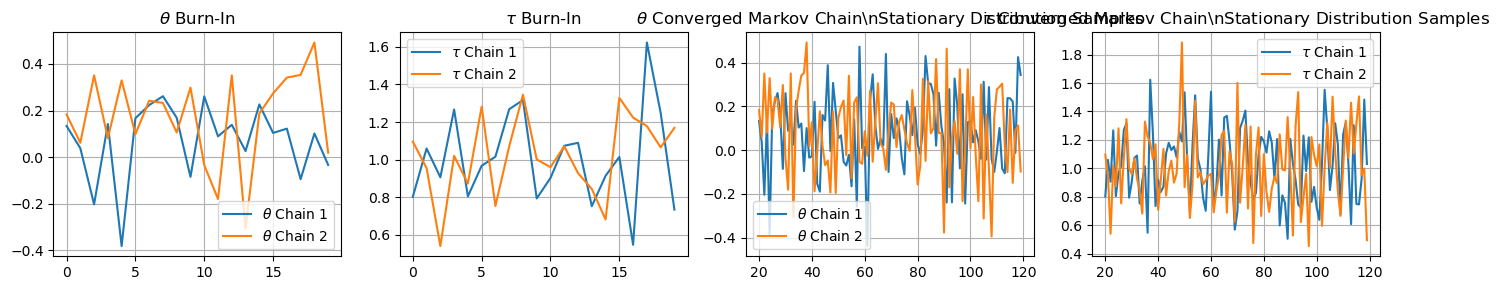

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Gibbs Sampler Function
def gibbs_sampler_v2(data, theta_prior_mean, tau_prior_prec, alpha, lambd, num_samples=10000, burn_in=20, chains=2):
    n = len(data)
    theta_samples = np.zeros((chains, num_samples))
    tau_samples = np.zeros((chains, num_samples))

    # Initialize theta
    theta_samples[:, 0] = np.random.uniform(-5, 5, size=chains)

    for c in range(chains):
        for g in range(1, num_samples):
            # Update tau | theta, data
            shape_tau = (n + alpha) / 2
            rate_tau = (lambd + np.sum((data - theta_samples[c, g - 1])**2)) / 2
            tau_samples[c, g] = stats.gamma.rvs(a=shape_tau, scale=1 / rate_tau)

            # Update theta | tau, data
            tau_n = tau_samples[c, g] * n
            variance_theta = 1 / (tau_n + tau_prior_prec)
            mean_theta = (tau_n * np.mean(data) + tau_prior_prec * theta_prior_mean) * variance_theta
            theta_samples[c, g] = stats.norm.rvs(loc=mean_theta, scale=np.sqrt(variance_theta))

    # Discard burn-in samples
    return theta_samples[:, burn_in:], tau_samples[:, burn_in:]

# Data and Prior Parameters
n = 30
data = stats.norm(loc=0, scale=1).rvs(size=n)
theta_prior_mean = 0  # Prior mean for theta
tau_prior_prec = 1    # Prior precision (1/variance) for theta
alpha = 2             # Shape parameter for tau
lambd = 1             # Rate parameter for tau

# Run Gibbs Sampler
theta_samples, tau_samples = gibbs_sampler_v2(data, theta_prior_mean, tau_prior_prec, alpha, lambd)

# Visualization
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title(r"$\theta$ Burn-In")
ax[1].set_title(r"$\tau$ Burn-In")
ax[2].set_title(r"$\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title(r"$\tau$ Converged Markov Chain\nStationary Distribution Samples")

burn = 20
demo = 120
for c in range(2):
    ax[0].plot(theta_samples[c, :burn], label=f"$\\theta$ Chain {c + 1}")
    ax[1].plot(tau_samples[c, :burn], label=f"$\\tau$ Chain {c + 1}")
    ax[2].plot(np.arange(burn, demo), theta_samples[c, :demo-burn], label=f"$\\theta$ Chain {c + 1}")
    ax[3].plot(np.arange(burn, demo), tau_samples[c, :demo-burn], label=f"$\\tau$ Chain {c + 1}")

for axis in ax:
    axis.legend()
    axis.grid()

plt.tight_layout()
plt.show()


### Q3

*Read the following "conversation". My reactions to this initial text I was provied with are the colored font. Then either (A) provide an analagous derivation of this result for the multinomial-Dirichlet specification, or (B) just report that if the prior is a proper distribution then the posterior is proportional to the joint distribution as Bayes Theorem tells us and describe how one might therefore identify the exact distribution of the posterior by just looking at the joint but that finally all this is moot and beside the point because as Bayesians we're going to trade any functional forms of distributions for samples from those distributions to just make histograms and belief (credible interval probability) statements based on those anyway...*

Suppose we have the following model setup:
\begin{align*}
    x_1,...,x_n &\overset{iid}{\sim} \text{Bernoulli}(\theta)\\
    \theta &\sim \text{Beta}(a, b)
\end{align*}

The joint likelihood distribution of ~~x_1,...,x_n~~ <span style='color:red'> $\sum_i x_i$</span> $| \theta$ is $\text{Binomial}(n, \theta)$. Now, let's consider the posterior:
\begin{align*}
    p(\theta | x_1,...,x_n) &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{p(x_1,...,x_n)} = \color{red}{\frac{p(\mathbf{x} | \theta)p(\theta)}{p(\mathbf{x})}}\\
    &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\int p(x_1,...,x_n | \theta )p(\theta) d\theta} = \color{red}{\frac{p(\mathbf{x}| \theta)p(\theta)}{\int p(\mathbf{x} | \theta )p(\theta) d\theta}}
\end{align*}

We can directly calculate the above if the denominator is finite. We tend to use proportionality arguments in this class, but to build some intuition <span style='color:red'>Bayes theorem is $p(\theta | \mathbf{x}) = \frac{p(\mathbf{x} | \theta )p(\theta)}{p(x)}$ and (if we know $\mathbf{x}$) then $p(\mathbf{x})$ is a constant so we must gather all $\theta$ related terms in our mathematical expression (dropping anything else which is any other constant) and see if we know of any statistical distribution that when scaled by a constant could exactly replicate our math as a function of $\theta$</span>, <span style='color:blue'>but if by "intuition" you mean the next 10 lines of derivation because you refuse to believe that the posterior is proportional to the joint (for proper priors) as Bayes Theorem claims</span> let's formally calculate that integral for the Beta-Binomial problem:

$\scriptsize
\begin{align*}
    \int p(\overset{\color{red}{\textrm{You meant } \sum_i x_i}}{x_1,...,x_n} | \theta )p(\theta) d\theta &= \int_0^1 \color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}} \overset{\color{blue}{\textrm{just this alone is a Bernoulli likelihood}}}{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i}} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\theta^{a-1}(1-\theta)^{b-1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\int_0^1 \theta^{\sum_i x_i + a - 1}(1-\theta)^{n-\sum_i x_i + b - 1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}\int_0^1 \frac{\Gamma(a+b+n)}{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}\theta^{\sum_i x_i + a - 1}(1-\theta)^{n-\sum_i x_i + b - 1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}\\& \text{ (because we have written the density formula above, which integrates to } 1)\\    
  & \color{blue}{\textrm{(But why stop there shouldn't we prove the integral is equal to 1 for "intuition"?)}}\\
    & \color{red}{\textrm{(if "intuition" may assume a density has area 1 then prove or believe Bayes Theorem)}}\\
    & \color{purple}{\textrm{Proof: $p(\theta|\mathbf{x})p(\mathbf{x}) = p(\mathbf{x}|\theta)p(\theta) \Rightarrow p(\theta|\mathbf{x}) = \frac{p(\mathbf{x}|\theta)p(\theta)}{p(\mathbf{x})}$}} \\    
    & \color{green}{\textrm{(Bayes Theorem is the formula for a posterior distribution if the prior is proper)}}\\
    & \color{blue}{\textrm{(If you believe it then the posterior is proportional to the joint and must have area 1)}}\\
    & \color{red}{\textrm{(Can you recognize what distribution for $\theta$ would be proportional to the given joint?)}}\\
    & \color{green}{\textrm{(There's only gonna be one... can't be two... can you find one distribution that does it?)}}\\
\end{align*}$

Now, we can directly plug in to our Bayes formula to directly calculate the posterior:

$\begin{align*}
    p(\theta | x_1,...,x_n) &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\int p(x_1,...,x_n | \theta )p(\theta) d\theta} \\
    &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}} \overset{\color{blue}{\textrm{just this alone is a Bernoulli likelihood}}}{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i}} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\theta^{a-1}(1-\theta)^{b-1}}{\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i} \theta^{a-1}(1-\theta)^{b-1}}{\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\Gamma(a+b+n)}{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}\theta^{\sum_i x_i + a-1}(1-\theta)^{n-\sum_i x_i+b-1} \\
    &= \text{Beta}(a+ \sum_i x_i, b + n - \sum_i x_i)
\end{align*}$

<span style='color:blue'>
So the structure of this "proof" providing the right kind of "intution" you'll apparently need to feel comfortable and safe about proportionality (if believing that the posterior is proportional to the joint as Bayes Theorem claims is a step too far for you) is...</span>

$\color{green}{\require{cancel}
\begin{align}
\frac{p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}} &={} \frac{\cancel{c_xc_\theta} c p(\boldsymbol{\theta}|\textbf{x})}{\cancel{c_xc_\theta} \int c p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}}\\
&={} \frac{c p(\boldsymbol{\theta}|\textbf{x})}{ c \int \xcancel{\frac{1}{c} c} p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}} =  \frac{c p(\boldsymbol{\theta}|\textbf{x})}{ c \cancel{\int p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}}^1} = \frac{\xcancel{c} p(\boldsymbol{\theta}|\textbf{x})}{ \xcancel{c} } = p(\boldsymbol{\theta}|\textbf{x})\\
\end{align}}
$

<span style='color:blue'>
Or here's an even more direct way to show this...
</span>

$\color{red}{
\begin{align*}
\frac{p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
 &={} \frac{p(\boldsymbol{\theta}|\textbf{x})p(\textbf{x})}{p(\textbf{x})} \\
  &={} p(\boldsymbol{\theta}|\textbf{x})
\end{align*}}
$    



We can see that when we have ~~**conjugate** priors (where the prior and posterior have the same form)~~ <u>**just any (propor) prior**</u>, the denominator in Bayes rule amounts to any normalizing constants in the likelihood and prior (that allow for the densities to integrate to 1 times the inverse of the equivalent normalizing constant of the posterior. Once we plug this back in to Bayes formula and cancel and rearrange terms, this amounts to multiplying the normalizing constant of the posterior with the portion of the posterior that relies on the parameter. This sort of derivation isn't unique to conjugate priors; as long as we can recognize the family in which the product of the prior and likelihood belong to, the integral in the denominator can be solved by simplifying the term in the integral to the precise density (which occurs by moving normalizing constants outside of the integral, and introducing the normalizing constant for that new density). This is the technique we used to solve the integral above.

As a result, we can use a proportionality argument to skip all of these mathematical derivations. If we can recognize the functional form of the product between the likelihood and prior as being in the family of another probability distribution, then that is equivalent to moving around these normalizing constants to simplify integrals.



# Q3

### Model Setup
The Multinomial-Dirichlet model is a generalization of the Beta-Binomial model. Observed data:

$$
\mathbf{x}=\left(x_1, x_2, \ldots, x_k\right) \sim \operatorname{Multinomial}(n, \boldsymbol{\theta})
$$


where $n=\sum_{i=1}^k x_i$ and  $\boldsymbol{\theta}=\left(\theta_1, \theta_2, \ldots, \theta_k\right)$ 

which it satisfies $\sum_{i=1}^k \theta_i=1$.

### Likelihood and Prior

Prior distribution:

$$
\boldsymbol{\theta} \sim \operatorname{Dirichlet}\left(\alpha_1, \alpha_2, \ldots, \alpha_k\right)
$$

The goal is to derive the posterior distribution $p(\boldsymbol{\theta} \mid \mathbf{x})$.

From Bayes' theorem:

$$
p(\boldsymbol{\theta} \mid \mathbf{x}) \propto p(\mathbf{x} \mid \boldsymbol{\theta}) p(\boldsymbol{\theta})
$$

The Multinomial likelihood is:

$$
p(\mathbf{x} \mid \boldsymbol{\theta})=\frac{n!}{x_{1}!x_{2}!\cdots x_{k}!} \prod_{i=1}^k \theta_i^{x_i}
$$


The Dirichlet prior is:

$$
p(\boldsymbol{\theta})=\frac{\Gamma\left(\sum_{i=1}^k \alpha_i\right)}{\prod_{i=1}^k \Gamma\left(\alpha_i\right)} \prod_{i=1}^k \theta_i^{\alpha_i-1}
$$

The joint distribution is:

$$
p(\mathbf{x}, \boldsymbol{\theta}) \propto p(\mathbf{x} \mid \boldsymbol{\theta}) p(\boldsymbol{\theta})
$$

Substituting the equations above:

$$
p(\mathbf{x}, \boldsymbol{\theta}) \propto \prod_{i=1}^k \theta_i^{x_i} \prod_{i=1}^k \theta_i^{\alpha_i-1}
$$

Combine the powers of $\theta_i$ :

$$
p(\mathbf{x}, \boldsymbol{\theta}) \propto \prod_{i=1}^k \theta_i^{x_i+\alpha_i-1}
$$

The posterior distribution is proportional to the joint distribution:

$$
p(\boldsymbol{\theta} \mid \mathbf{x}) \propto \prod_{i=1}^k \theta_i^{x_i+\alpha_i-1}
$$

Recognizing the form, this matches the functional form of a Dirichlet distribution:

$$
\operatorname{Dirichlet}\left(\beta_1, \beta_2, \ldots, \beta_k\right) \propto \prod_{i=1}^k \theta_i^{\beta_i-1}
$$

where $\beta_i=x_i+\alpha_i$.

Thus, the posterior distribution is:

$$
\boldsymbol{\theta} \mid \mathbf{x} \sim \operatorname{Dirichlet}\left(\alpha_1+x_1, \alpha_2+x_2, \ldots, \alpha_k+x_k\right)
$$